# Testing code for my 2.5D forward simulation and inversion using simpeg

In this file I define all the functions explicitly, which in the `.py` files I import from `functions.py` instead.

In [1]:
# imports

# SimPEG functionality
from simpeg.electromagnetics.static import resistivity as dc
from simpeg.utils import model_builder, download
from simpeg.utils.solver_utils import get_default_solver
from simpeg.utils.io_utils import read_dcip2d_ubc
from simpeg.utils.io_utils.io_utils_electromagnetics import write_dcip2d_ubc
from simpeg import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
)
from simpeg.electromagnetics.static.utils.static_utils import (
    generate_dcip_sources_line,
    generate_survey_from_abmn_locations,
    pseudo_locations,
    plot_pseudosection,
    apparent_resistivity_from_voltage,
)

# Suppress the DefaultSolverWarning
import warnings
import simpeg.utils.solver_utils  # Ensure the module is imported

warnings.filterwarnings(
    "ignore", category=simpeg.utils.solver_utils.DefaultSolverWarning
)

# discretize functionality
from discretize import TreeMesh, TensorMesh
from discretize.utils import active_from_xyz


# Common Python functionality
import os
import numpy as np
from scipy.interpolate import interp1d
from scipy.spatial import cKDTree
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import tarfile

mpl.rcParams.update({"font.size": 14})  # default font size
cmap = mpl.cm.RdYlBu_r  # default colormap

Read in survey data

In [ ]:
file_path = "data/Project4_Wenner_1.dat"

with open(file_path, "r") as file:
    lines = file.readlines()

num_data_points = int(lines[6].strip())  # Number of data points

# Read the data section
A = np.zeros((num_data_points, 2))
B = np.zeros((num_data_points, 2))
M = np.zeros((num_data_points, 2))
N = np.zeros((num_data_points, 2))
dobs = np.zeros(num_data_points)
error = np.zeros(num_data_points)

data_start_line = 12
for i, line in enumerate(lines[data_start_line : data_start_line + num_data_points]):
    values = line.strip().split()
    if len(values) >= 11:
        A[i] = [float(values[1]), float(values[2])]
        B[i] = [float(values[3]), float(values[4])]
        M[i] = [float(values[5]), float(values[6])]
        N[i] = [float(values[7]), float(values[8])]
        dobs[i] = float(values[9])  # Voltage
        error[i] = float(values[10])  # Error percentage

In [ ]:
# Generate the survey
survey = generate_survey_from_abmn_locations(
    locations_a=A, locations_b=B, locations_m=M, locations_n=N, data_type="volt"
)

In [ ]:
# Topo from electrode positions (flat)
topo_2d = np.unique(np.vstack([A, B, M, N]), axis=0)

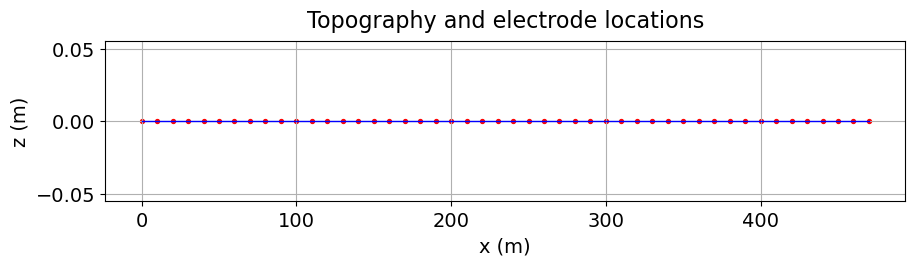

In [ ]:
fig = plt.figure(figsize=(10, 2))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(topo_2d[:, 0], topo_2d[:, 1], color="b", linewidth=1)
ax.scatter(topo_2d[:, 0], topo_2d[:, 1], 8, "r")
# ax.set_xlim([x_topo.min(), x_topo.max()])
ax.set_xlabel("x (m)", labelpad=5)
ax.set_ylabel("z (m)", labelpad=5)
ax.grid(True)
ax.set_title("Topography and electrode locations", fontsize=16, pad=10)
plt.show(fig)

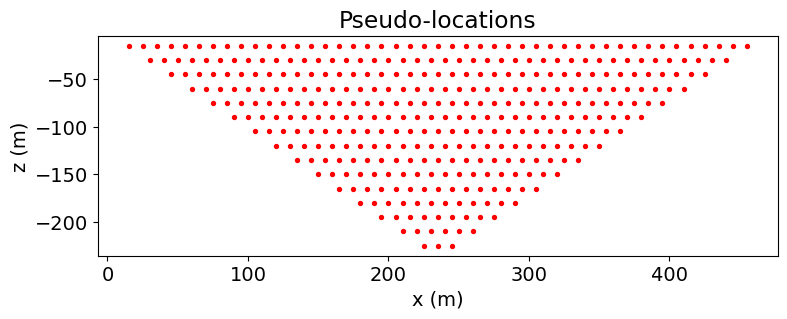

In [6]:
pseudo_locations_xz = pseudo_locations(survey)
fig = plt.figure(figsize=(8, 2.75))
ax = fig.add_axes([0.1, 0.1, 0.85, 0.8])
ax.scatter(pseudo_locations_xz[:, 0], pseudo_locations_xz[:, -1], 8, "r")
ax.set_xlabel("x (m)")
ax.set_ylabel("z (m)")
ax.set_title("Pseudo-locations")
plt.show()

## Tree Mesh

In [ ]:
dh = 5  # minimum cell width
dom_width_x = np.max(topo_2d[:, 0]) - np.min(topo_2d[:, 0])  # domain width x
dom_width_z = np.max(topo_2d[:, 1]) - (np.min(topo_2d[:, 1] - 250))  # domain width z
dz = 5
nbcx = 2 ** (
    int(np.round(np.log(dom_width_x / dh) / np.log(2.0))) + 1
)  # num. base cells x
nbcz = 2 ** (int(np.ceil(np.log(dom_width_z / dz) / np.log(2.0))))  # num. base cells z


# Define the base mesh with top at z = 0 m.
hx = [(dh, nbcx)]
hz = [(dz, nbcz)]
mesh = TreeMesh([hx, hz], x0="0N", diagonal_balance=True)

# Shift top to maximum topography
mesh.origin = mesh.origin + np.r_[-200, np.max(topo_2d[:, 1])]

# Mesh refinement based on topography
mesh.refine_surface(
    topo_2d,
    padding_cells_by_level=[10, 10, 5, 5],
    finalize=False,
)

# Extract unique electrode locations.
unique_locations = survey.unique_electrode_locations

# Mesh refinement near electrodes.
# mesh.refine_points(
#     unique_locations, padding_cells_by_level=[1, 1, 1, 1], finalize=False
# )

mesh.finalize()

In [8]:
print("# of cells: {}".format(mesh.n_cells))  # Number of cells
print("# of x-faces: {}".format(mesh.n_faces_x))  # Number of x-faces
print("Origin: {}".format(mesh.origin))  # bottom-southewest corner
print("Max cell volume: {}".format(mesh.cell_volumes.max()))  # Largest cell size
print(mesh.cell_centers[0:5, :])  # Cell center locations

# of cells: 2770
# of x-faces: 2760
Origin: [-200. -320.]
Max cell volume: 6400.0
[[-180. -300.]
 [-140. -300.]
 [-190. -270.]
 [-170. -270.]
 [-190. -250.]]


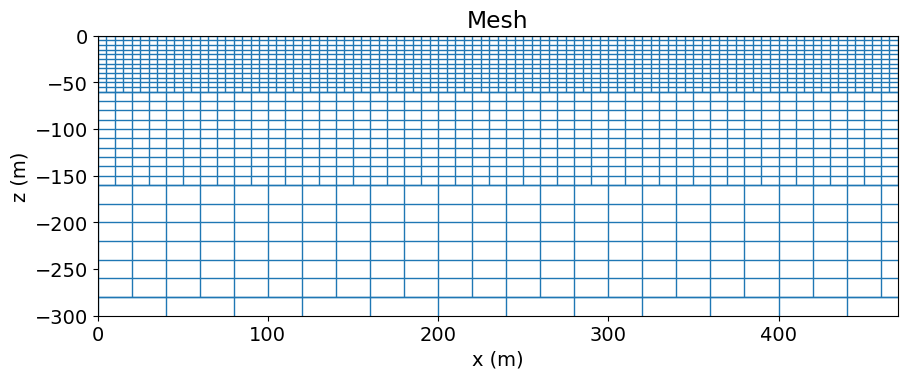

In [9]:
fig = plt.figure(figsize=(10, 4))

ax1 = fig.add_axes([0.14, 0.17, 0.8, 0.7])
mesh.plot_grid(ax=ax1, linewidth=1)
ax1.grid(False)
ax1.set_xlim(np.min(topo_2d[:, 0]), np.max(topo_2d[:, 0]))
ax1.set_ylim(np.min(topo_2d[:, 1]) - 300, np.max(topo_2d[:, 1]))
ax1.set_title("Mesh")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

plt.show()

## Define active cells

In [10]:
# Indices of the active mesh cells from topography (e.g. cells below surface)
active_cells = active_from_xyz(mesh, topo_2d)

# number of active cells
n_active = np.sum(active_cells)

In [ ]:
air_resistivity = 1e8
permafrost_resistivity = 600
bedrock_resistivity = 10000
ice_resistivity = 1000
unfrozen_resistivity = 400

In [111]:
# Define conductivity model
resistivity_model = bedrock_resistivity * np.ones(n_active)

# ind_perma = model_builder.get_indices_block(
#     np.r_[-1000, -80], np.r_[5000, 0], mesh.cell_centers[active_cells, :]
# )

# resistivity_model[ind_perma] = permafrost_resistivity

ind_ice = model_builder.get_indices_block(
    np.r_[80, -60], np.r_[250, -30], mesh.cell_centers[active_cells, :]
)
resistivity_model[ind_ice] = ice_resistivity

ind_ice_wedge = model_builder.get_indices_block(
    np.r_[350, -80], np.r_[360, -10], mesh.cell_centers[active_cells, :]
)
resistivity_model[ind_ice_wedge] = ice_resistivity

# Define log-resistivity model
log_resistivity_model = np.log(resistivity_model)
conductivity_model = 1 / resistivity_model

In [ ]:
# Conductivity map. Model parameters are conductivities for all active cells.
conductivity_map = maps.InjectActiveCells(mesh, active_cells, 1 / air_resistivity)

resistivity_map = maps.InjectActiveCells(mesh, active_cells, air_resistivity)

In [113]:
# Generate a mapping to ignore inactice cells in plot
plotting_map = maps.InjectActiveCells(mesh, active_cells, np.nan)

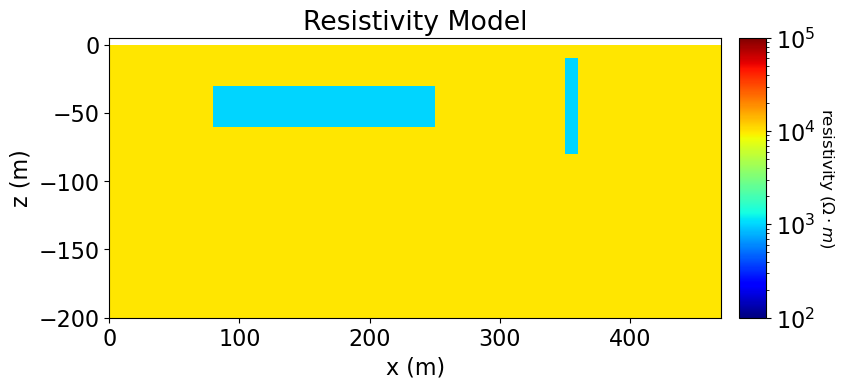

In [114]:
fig = plt.figure(figsize=(9, 4))

norm = LogNorm(vmin=1e2, vmax=1e5)

ax1 = fig.add_axes([0.14, 0.17, 0.68, 0.7])
mesh.plot_image(
    plotting_map * resistivity_model,
    ax=ax1,
    grid=False,
    pcolor_opts={"norm": norm, "cmap": mpl.cm.jet},
)
ax1.set_xlim(np.min(topo_2d[:, 0]), np.max(topo_2d[:, 0]))
ax1.set_ylim(np.max(topo_2d[:, 1]) - 200, np.max(topo_2d[:, 1] + 5))
ax1.set_title("Resistivity Model")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.84, 0.17, 0.03, 0.7])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.jet
)
cbar.set_label(r"resistivity ($\Omega \cdot m$)", rotation=270, labelpad=15, size=12)

plt.show()

In [115]:
survey.drape_electrodes_on_topography(mesh, active_cells, option="top")

In [116]:
# DC simulation for a conductivity model
simulation_con = dc.simulation_2d.Simulation2DNodal(
    mesh, survey=survey, sigmaMap=conductivity_map, storeJ=True
)

# DC simulation for a resistivity model
simulation_res = dc.simulation_2d.Simulation2DNodal(
    mesh, survey=survey, rhoMap=resistivity_map, storeJ=True
)

survey.set_geometric_factor(space_type="half-space")

dpred_con = simulation_con.dpred(conductivity_model)
dpred_res = simulation_res.dpred(resistivity_model)

In [117]:
print("MAX ABSOLUTE ERROR = {}".format(np.max(np.abs(dpred_con - dpred_res))))

MAX ABSOLUTE ERROR = 0.0


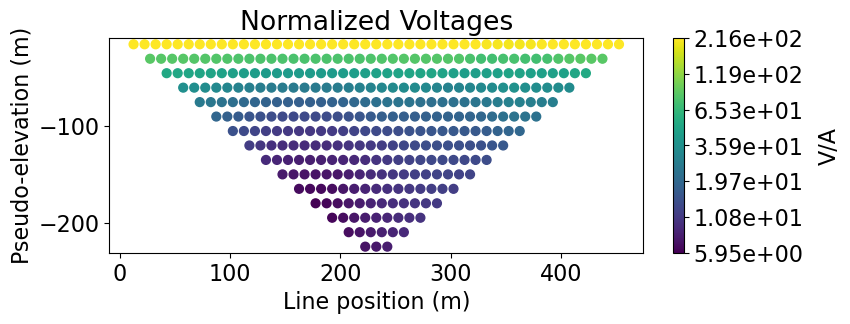

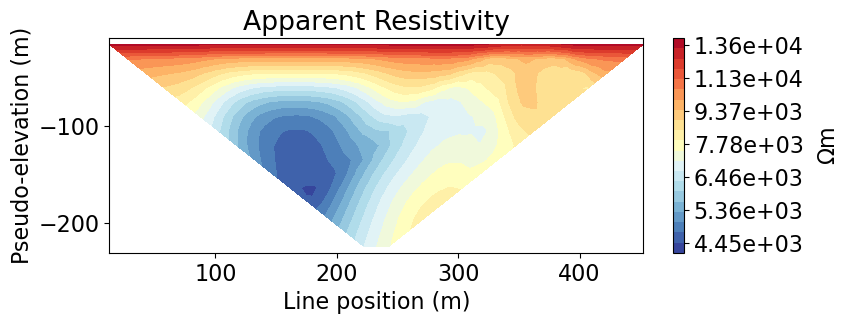

In [118]:
# Plot voltages pseudo-section
fig = plt.figure(figsize=(8, 2.75))
ax1 = fig.add_axes([0.1, 0.15, 0.75, 0.78])
plot_pseudosection(
    survey,
    dobs=np.abs(dpred_res),
    plot_type="scatter",
    ax=ax1,
    scale="log",
    cbar_label="V/A",
    scatter_opts={"cmap": mpl.cm.viridis},
)
ax1.set_title("Normalized Voltages")
plt.show()

# Get apparent conductivities from volts and survey geometry
apparent_conductivities = 1 / apparent_resistivity_from_voltage(survey, dpred_con)
apparent_resistivities = apparent_resistivity_from_voltage(survey, dpred_res)

# Plot apparent conductivity pseudo-section
fig = plt.figure(figsize=(8, 2.75))
ax1 = fig.add_axes([0.1, 0.15, 0.75, 0.78])
plot_pseudosection(
    survey,
    dobs=apparent_resistivities,
    plot_type="contourf",
    ax=ax1,
    scale="log",
    cbar_label="$\Omega$m",
    mask_topography=True,
    contourf_opts={"levels": 20, "cmap": mpl.cm.RdYlBu_r},
)
ax1.set_title("Apparent Resistivity")
plt.show()

In [119]:
# Add 5% Gaussian noise to each datum
rng = np.random.default_rng(seed=225)
std = 0.05 * np.abs(dpred_res)
dc_noise = rng.normal(scale=std, size=len(dpred_res))
dobs = dpred_res + dc_noise

data_dc = data.Data(survey, dobs=dobs, standard_deviation=std)

# 2.5D Least-squares inversion

In [120]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import tarfile

from discretize import TreeMesh
from discretize.utils import mkvc, active_from_xyz

from simpeg.utils import model_builder
from simpeg import (
    maps,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
    utils,
)
from simpeg.electromagnetics.static import resistivity as dc
from simpeg.electromagnetics.static.utils.static_utils import (
    plot_pseudosection,
)
from simpeg.utils.io_utils.io_utils_electromagnetics import read_dcip2d_ubc


mpl.rcParams.update({"font.size": 16})
# sphinx_gallery_thumbnail_number = 4

In [ ]:
dobs = dpred_con
standard_deviation = 0.05 * np.abs(dobs)
simulation_res

In [122]:
# Define conductivity model in S/m (or resistivity model in Ohm m)

background_resistivity = bedrock_resistivity

# active_map = maps.InjectActiveCells(mesh, ind_active, np.exp(air_conductivity))
nC = int(active_cells.sum())

# Define model
starting_resistivity_model = background_resistivity * np.ones(nC)

In [123]:
data_dc

In [124]:
# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# Within the data misfit, the residual between predicted and observed data are
# normalized by the data's standard deviation.
dmis = data_misfit.L2DataMisfit(data=data_dc, simulation=simulation_res)

# Define the regularization (model objective function)
reg = regularization.WeightedLeastSquares(
    mesh,
    active_cells=active_cells,
    reference_model=starting_resistivity_model,
)

reg.reference_model_in_smooth = True  # Reference model in smoothness term

# Define how the optimization problem is solved. Here we will use an
# Inexact Gauss Newton approach.
opt = optimization.InexactGaussNewton(
    maxIter=20, maxIterLS=10, maxIterCG=10, tolCG=1e-3
)

# Here we define the inverse problem that is to be solved
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

In [125]:
# Apply and update sensitivity weighting as the model updates
update_sensitivity_weighting = directives.UpdateSensitivityWeights()

# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e1)

# Set the rate of reduction in trade-off parameter (beta) each time the
# the inverse problem is solved. And set the number of Gauss-Newton iterations
# for each trade-off paramter value.
beta_schedule = directives.BetaSchedule(coolingFactor=3, coolingRate=2)

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputEveryIteration(save_txt=False)

# Setting a stopping criteria for the inversion.
target_misfit = directives.TargetMisfit(chifact=1)

# Update preconditioner
update_jacobi = directives.UpdatePreconditioner()

directives_list = [
    update_sensitivity_weighting,
    starting_beta,
    beta_schedule,
    save_iteration,
    target_misfit,
    update_jacobi,
]

In [126]:
# Here we combine the inverse problem and the set of directives
dc_inversion = inversion.BaseInversion(inv_prob, directiveList=directives_list)

# Run inversion
recovered_resistivity_model = dc_inversion.run(starting_resistivity_model)


Running inversion with SimPEG v0.23.0

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation2DNodal problem***
                        


/Users/cara/opt/miniconda3/envs/eosc-556-project/lib/python3.11/site-packages/pymatsolver/solvers.py:415: FutureWarning: In Future pymatsolver v0.4.0, passing a vector of shape (n, 1) to the solve method will return an array with shape (n, 1), instead of always returning a flattened array. This is to be consistent with numpy.linalg.solve broadcasting.
  return self.solve(val)


model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.53e-07  4.36e+04  0.00e+00  4.36e+04    6.23e-01      0              
   1  2.53e-07  2.15e+03  2.60e+10  8.72e+03    4.79e-02      0              
   2  8.43e-08  1.95e+03  2.46e+10  4.02e+03    8.10e-02      0              
   3  8.43e-08  9.08e+02  2.71e+10  3.19e+03    6.74e-02      1              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 8.3296e+02 <= tolF*(1+|f0|) = 4.3594e+03
1 : |xc-x_last| = 2.2294e+04 <= tolX*(1+|x0|) = 5.2631e+04
1 : |proj(x-g)-x|    = 6.7410e-02 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 6.7410e-02 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =      20    <= iter          =      3
------------------------- DONE! -------------------------


In [127]:
recovered_resistivity_model

array([8976.49613192, 8883.79615951, 8947.72838667, ..., 9497.10870589,
       9468.37119215, 9530.41554111], shape=(2770,))

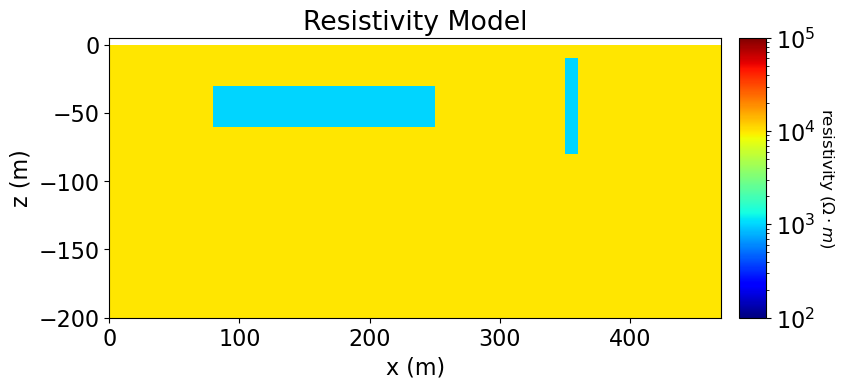

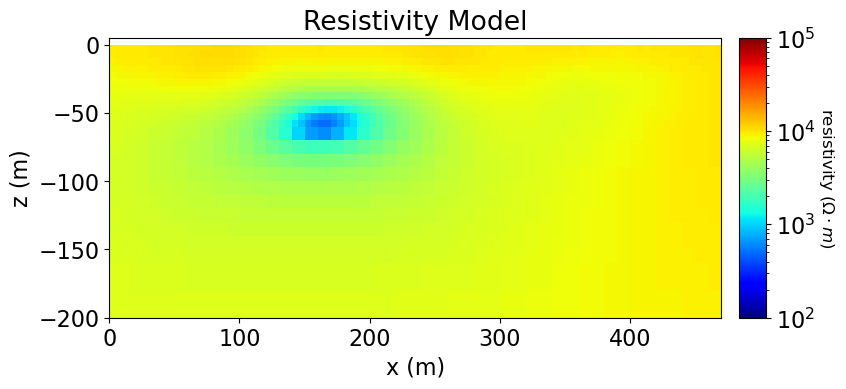

In [128]:
fig = plt.figure(figsize=(9, 4))

norm = LogNorm(vmin=1e2, vmax=1e5)

ax1 = fig.add_axes([0.14, 0.17, 0.68, 0.7])
mesh.plot_image(
    plotting_map * resistivity_model,
    ax=ax1,
    grid=False,
    pcolor_opts={"norm": norm, "cmap": mpl.cm.jet},
)
ax1.set_xlim(np.min(topo_2d[:, 0]), np.max(topo_2d[:, 0]))
ax1.set_ylim(np.max(topo_2d[:, 1]) - 200, np.max(topo_2d[:, 1] + 5))
ax1.set_title("Resistivity Model")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.84, 0.17, 0.03, 0.7])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.jet
)
cbar.set_label(r"resistivity ($\Omega \cdot m$)", rotation=270, labelpad=15, size=12)

plt.show()

fig = plt.figure(figsize=(9, 4))

norm = LogNorm(vmin=1e2, vmax=1e5)

ax1 = fig.add_axes([0.14, 0.17, 0.68, 0.7])
mesh.plot_image(
    plotting_map * recovered_resistivity_model,
    ax=ax1,
    grid=False,
    pcolor_opts={"norm": norm, "cmap": mpl.cm.jet},
)
ax1.set_xlim(np.min(topo_2d[:, 0]), np.max(topo_2d[:, 0]))
ax1.set_ylim(np.max(topo_2d[:, 1]) - 200, np.max(topo_2d[:, 1] + 5))
ax1.set_title("Resistivity Model")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.84, 0.17, 0.03, 0.7])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.jet
)
cbar.set_label(r"resistivity ($\Omega \cdot m$)", rotation=270, labelpad=15, size=12)

plt.show()